In [1]:
!pip install yfinance pandas_datareader forex-python eia wbdata newsapi-python textblob vaderSentiment statsmodels scikit-learn matplotlib seaborn sqlalchemy prophet

In [2]:
import yfinance as yf
import pandas_datareader.data as web
from forex_python.converter import CurrencyRates
import wbdata
import requests
from newsapi import NewsApiClient
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
# **Brent Oil Prices**

brent_data = pd.read_csv('/content/drive/MyDrive/Copy of BrentOilPrices.csv')

# Parse the 'Date' column with the specified format
brent_data['Date'] = pd.to_datetime(brent_data['Date'], format='%d-%b-%y', errors='coerce')

# Drop rows with unparseable dates if any
brent_data = brent_data.dropna(subset=['Date'])

brent_data.set_index('Date', inplace=True)



In [65]:
brent_data.head()

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [7]:
# **Economic Indicators (GDP, Inflation, Unemployment)**
# Use FRED via pandas_datareader
gdp_data = web.DataReader("GDP", "fred", start="2000-01-01")
inflation_data = web.DataReader("CPIAUCSL", "fred", start="2000-01-01")
unemployment_data = web.DataReader("UNRATE", "fred", start="2000-01-01")

In [11]:
# **Exchange Rates**
# Get USD to Euro exchange rates
c = CurrencyRates()
usd_eur_rates = pd.DataFrame(columns=['Date', 'Exchange_Rate'])
for date in pd.date_range(start="2000-01-01", end="2023-12-31", freq='M'):
    try:
        rate = c.get_rate('USD', 'EUR', date)
        usd_eur_rates = usd_eur_rates.append({'Date': date, 'Exchange_Rate': rate}, ignore_index=True)
    except:
        pass
usd_eur_rates.set_index('Date', inplace=True)

<ipython-input-11-35b3705716fd>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for date in pd.date_range(start="2000-01-01", end="2023-12-31", freq='M'):


In [23]:
# **Technological and Energy Data**
# Collect energy data from the EIA and World Bank
# (Note: Requires an API key from EIA)
eia_api_key = 'ChTKRInGT96dzTkPSTWjO5MhmWngQfWTULb80HgW'
eia_url = f"https://api.eia.gov/series/?api_key={eia_api_key}&series_id=TOTAL.RETCBUSA.A"
renewable_energy_data = requests.get(eia_url).json()

In [66]:
# **4. Data Preprocessing**

# Merge all datasets on date
economic_data = pd.concat([brent_data, gdp_data, inflation_data, unemployment_data], axis=1).dropna()

In [67]:
economic_data.head()

,Price,GDP,CPIAUCSL,UNRATE
2001-10-01,21.22,10660.465,177.6,5.3
2002-04-01,26.06,10887.460,179.3,5.9
2002-07-01,25.65,10984.040,180.0,5.8
2002-10-01,29.42,11061.433,181.2,5.7
2003-04-01,27.94,11312.766,183.2,6.0


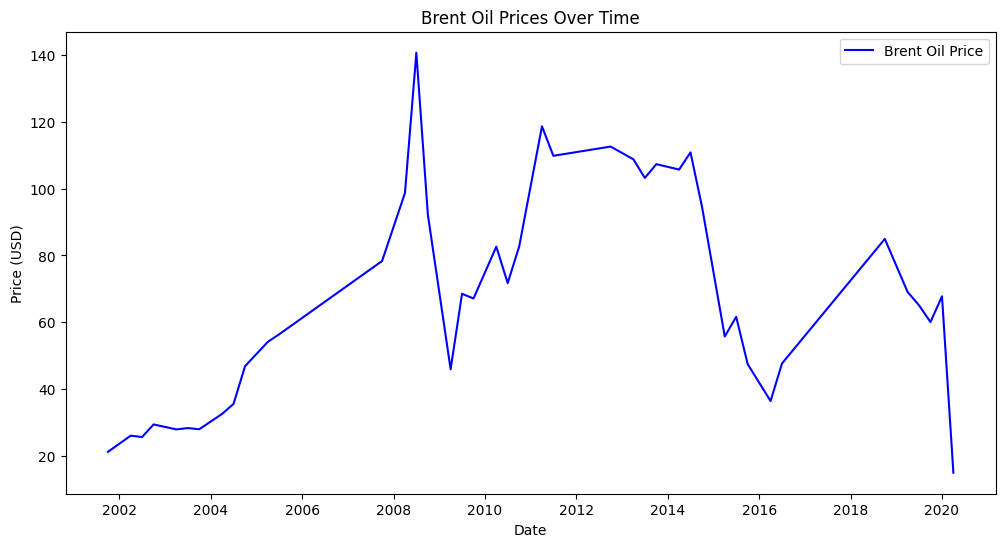

In [68]:

# **5. Exploratory Data Analysis (EDA)**

# Plotting Brent oil prices
plt.figure(figsize=(12, 6))
plt.plot(economic_data['Price'], color='blue', label='Brent Oil Price')
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

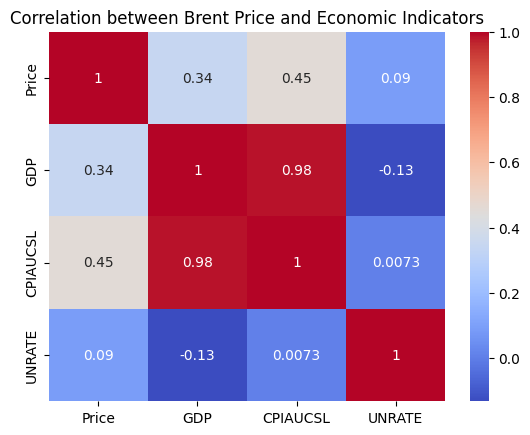

In [69]:
# Correlation heatmap of Brent prices and economic indicators
sns.heatmap(economic_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Brent Price and Economic Indicators")
plt.show()

In [41]:
# **6. Model Building**

# **ARIMA Model for Brent Oil Prices**
arima_model = ARIMA(economic_data['Price'], order=(1, 1, 1)).fit()
print(arima_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -180.839
Date:                Sun, 03 Nov 2024   AIC                            367.678
Time:                        17:32:06   BIC                            372.818
Sample:                             0   HQIC                           369.549
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7020      0.420      1.670      0.095      -0.122       1.526
ma.L1         -0.8217      0.342     -2.403      0.016      -1.492      -0.152
sigma2       396.0307     72.099      5.493      0.0

In [43]:
# **Vector Autoregression (VAR) for Multivariate Time Series Analysis**
var_model = VAR(economic_data[['Price', 'GDP', 'CPIAUCSL', 'UNRATE']])
var_result = var_model.fit()
print(var_result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 03, Nov, 2024
Time:                     17:34:02
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    19.9514
Nobs:                     41.0000    HQIC:                   19.4199
Log likelihood:          -604.573    FPE:                2.01311e+08
AIC:                      19.1155    Det(Omega_mle):     1.27049e+08
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const             209.471402       166.816597            1.256           0.209
L1.Price            0.947129         0.202283            4.682           0.000
L1.GDP              0.017620         0.013613            1.294      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [71]:
# **Prophet for Seasonality Analysis and Forecasting**

economic_data.reset_index(inplace=True)
prophet_data = economic_data[['index','Price']].rename(columns={'index': 'ds', 'Price': 'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoetmz4r2/eh6sf5ho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoetmz4r2/qi4pt9kp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32074', 'data', 'file=/tmp/tmpoetmz4r2/eh6sf5ho.json', 'init=/tmp/tmpoetmz4r2/qi4pt9kp.json', 'output', 'file=/tmp/tmpoetmz4r2/prophet_modelu0glua3w/prophet_model-20241103174926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:49:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:49:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [72]:
# Forecast future oil prices with Prophet
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

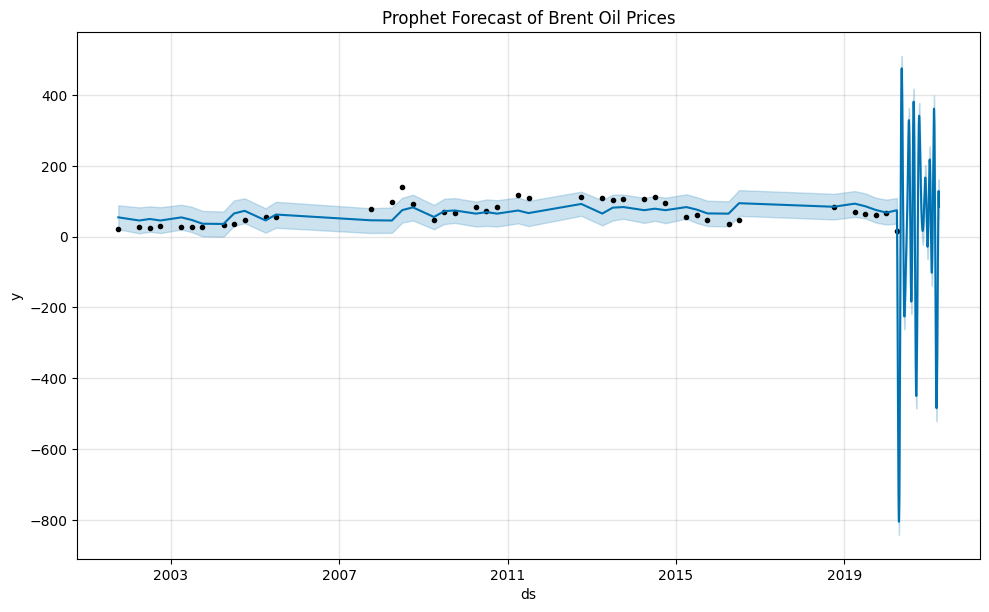

In [73]:
# Plot forecast
fig = prophet_model.plot(forecast)
plt.title("Prophet Forecast of Brent Oil Prices")
plt.show()

In [77]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluation function
def evaluate_model(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

# Predict with ARIMA for evaluation
arima_forecast = arima_model.forecast(steps=len(economic_data) - int(0.8 * len(economic_data)))
arima_eval = evaluate_model(economic_data['Price'].iloc[int(0.8 * len(economic_data)):], arima_forecast)
print("ARIMA Evaluation:", arima_eval)

ARIMA Evaluation: {'RMSE': 30.78947579537842, 'MAE': 28.48678551373957, 'R2': -1.4778581994748077}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:

import pickle

# Assuming 'prophet_model' is your trained Prophet model
model_filename = '/content/drive/MyDrive/prophet_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(prophet_model, f)

print(f"Model saved to {model_filename}")

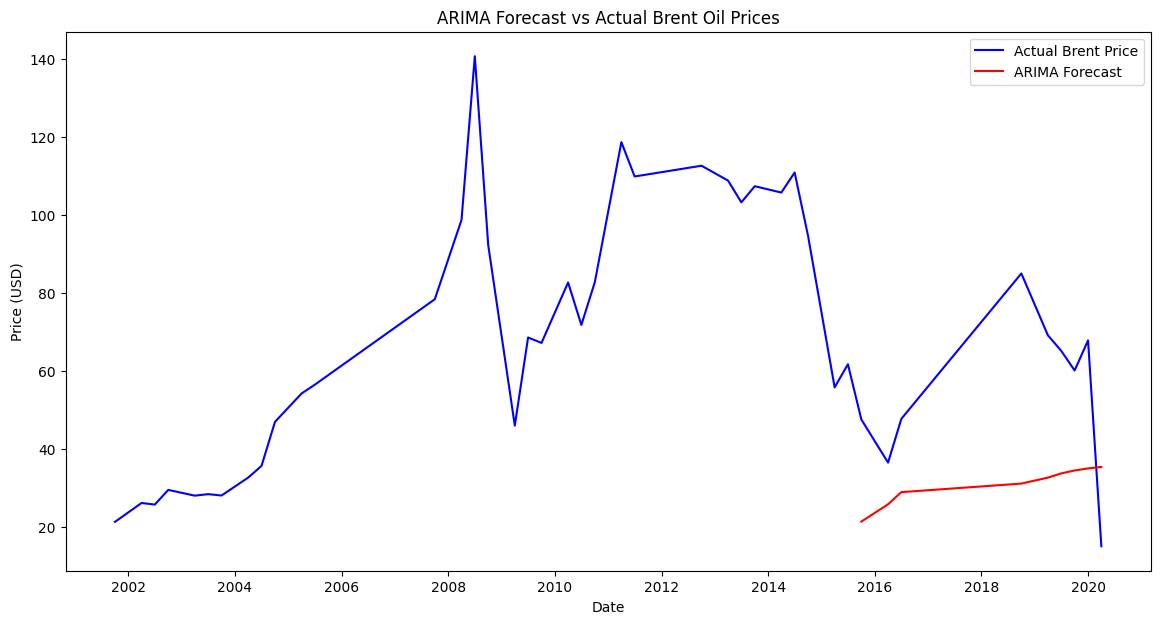

In [79]:
# **9. Insight Generation**

# Visualize actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(economic_data['index'], economic_data['Price'], label="Actual Brent Price", color="blue")
plt.plot(economic_data['index'][int(0.8 * len(economic_data)):], arima_forecast, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast vs Actual Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()